In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore")
#general
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
import pickle
from tqdm.auto import tqdm
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import random
import gc
import cv2
gc.enable()
import glob
pd.set_option('display.max_columns', None) 
from sklearn.linear_model import RidgeCV

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# augmentation
from albumentations.pytorch import ToTensorV2
import albumentations as A

# deep learning
import timm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau, StepLR, LambdaLR
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio
from PIL import Image
from tqdm.notebook import tqdm
tqdm.pandas()

# metrics
from sklearn.metrics import mean_squared_error

In [2]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [3]:
class Config:
    model_name = "swint_large224"
    base_dir = "/content/drive/MyDrive/petfinder"
    data_dir = "../input/petfinder-pawpularity-score/"
    meta_data_dir = "../input/trainmeta/"
    model_dir = "."
    output_dir = "."
    img_train_dir = os.path.join(data_dir, "train")
    img_test_dir = os.path.join(data_dir, "test")
    random_seed = 555
    n_epoch = 5
    n_fold = 5
    tta = True # calculate cv score in case TTA is executed
    tta_times = 4
    tta_beta = 1 / tta_times
    model_path = "swin_large_patch4_window7_224"
    pretrained = True
    inp_channels = 3
    im_size =  224
    lr = 2e-5
    opt_wd_non_norm_bias = 0.01
    opt_wd_norm_bias = 0
    opt_beta1 = 0.9
    opt_beta2 = 0.99
    opt_eps = 1e-5
    batch_size = 16
    epoch_step_valid = 3
    steps_per_epoch = 62
    num_workers = 8
    out_features = 1
    dropout = 0
    aug_decay_epoch = 4
    mixup = False
    if mixup:
        mixup_epoch = n_epoch
    else:
        mixup_epoch = 0
    mixup_alpha =0.2
    scheduler_name = "OneCycleLR" #OneCycleLR
    reduce_lr_factor = 0.6
    reduce_lr_patience = 1
    T_0 = 4 
    T_max =4
    T_mult =1
    min_lr = 1e-7
    max_lr =2e-5
    is_debug = False
    if is_debug:
        n_epoch = 1
        aug_decay_epoch = 1
        n_fold = 2
        n_sample_debug = 500
        tta_times = 2
        tta_beta = 1 / tta_times

In [4]:
def seed_everything(seed=Config.random_seed):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed%(2**32-1))
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False

seed_everything()
# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


In [5]:
img_train_dir = os.path.join(Config.data_dir, 'train')
def return_imgfilepath(name, folder=img_train_dir):
    path = os.path.join(folder, f'{name}.jpg')
    return path

train_file_path = os.path.join(Config.data_dir, 'train.csv')
train_df = pd.read_csv(train_file_path)

# set image filepath
train_df['file_path'] = train_df['Id'].progress_apply(lambda x: return_imgfilepath(x))
train_df.head()

  0%|          | 0/9912 [00:00<?, ?it/s]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


<AxesSubplot:>

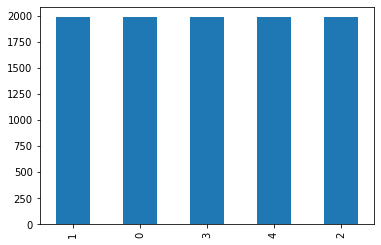

In [6]:
if Config.is_debug:
    train_df = train_df.sample(500).reset_index(drop = True)
train_df['norm_score'] = train_df['Pawpularity'] / 100
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['fold'] = -1

skf = StratifiedKFold(n_splits = Config.n_fold, shuffle=True, random_state =Config.random_seed)
for i, (_, train_index) in enumerate(skf.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [7]:
train_df[train_df['fold']==0].head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path,norm_score,bins,fold
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74,../input/petfinder-pawpularity-score/train/001...,0.74,32,0
13,006483b96ca9c09b7afed3e3d3af539d,0,1,1,1,0,0,0,0,1,1,0,0,41,../input/petfinder-pawpularity-score/train/006...,0.41,17,0
29,00b151a572c9aabedf8cfce0fa18be25,0,0,1,1,0,0,0,0,0,0,0,1,21,../input/petfinder-pawpularity-score/train/00b...,0.21,8,0
46,0126fe11deba78f84fd05cd5f12c5a4b,0,1,1,1,0,0,0,0,0,0,0,0,37,../input/petfinder-pawpularity-score/train/012...,0.37,15,0
52,01430d6ae02e79774b651175edd40842,0,1,1,1,0,0,0,1,0,0,1,0,28,../input/petfinder-pawpularity-score/train/014...,0.28,11,0


In [8]:
class PetDataset(Dataset):
    def __init__(self, image_filepaths, targets, transform=None):
        self.image_filepaths = image_filepaths
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.image_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.image_filepaths[idx]
        with open(image_filepath, 'rb') as f:
            image = Image.open(f)
            image_rgb = image.convert('RGB')
        image = np.array(image_rgb)

        if self.transform is not None:
            image = self.transform(image = image)["image"]
        
        image = image / 255 # convert to 0-1
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        target = self.targets[idx]

        image = torch.tensor(image, dtype = torch.float)
        target = torch.tensor(target, dtype = torch.float)
        return image, target

In [9]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB
def get_train_transforms(epoch, dim = Config.im_size):
    return A.Compose(
        [             
            # resize like Resize in fastai
            A.SmallestMaxSize(max_size=dim, p=1.0),
            A.RandomCrop(height=dim, width=dim, p=1.0),
            A.VerticalFlip(p = 0.5),
            A.HorizontalFlip(p = 0.5)
            #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ]
  )

def get_inference_fixed_transforms(mode=0, dim = Config.im_size):
    if mode == 0: # do not original aspects, colors and angles
        return A.Compose([
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
                #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ], p=1.0)
    elif mode == 1:
        return A.Compose([
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
                #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),,
                A.VerticalFlip(p = 1.0)
            ], p=1.0)    
    elif mode == 2:
        return A.Compose([
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
                #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                A.HorizontalFlip(p = 1.0)
            ], p=1.0)
    elif mode == 3:
        return A.Compose([
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
                #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
                A.Transpose(p=1.0)
            ], p=1.0)
        
def get_inference_random_transforms(mode=0, dim = Config.im_size):
    if mode == 0: # do not original aspects, colors and angles
        return A.Compose([
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
                #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ], p=1.0)
    else:
        return A.Compose(
            [            
                A.SmallestMaxSize(max_size=dim, p=1.0),
                A.CenterCrop(height=dim, width=dim, p=1.0),
                A.VerticalFlip(p = 0.5),
                A.HorizontalFlip(p = 0.5)
                #A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
            ]
      )

In [10]:
class PetNet(nn.Module):
    def __init__(
        self,
        model_name = Config.model_path,
        out_features = Config.out_features,
        inp_channels=Config.inp_channels,
        pretrained=Config.pretrained
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels, num_classes = out_features)
        self.custom_head = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )
    
    def forward(self, image):
        emb = self.model(image).squeeze(-1).squeeze(-1)
        output = self.custom_head(emb)
        return output

In [11]:
def divice_norm_bias(model): 
    norm_bias_params = []
    non_norm_bias_params = []
    except_wd_layers = ['norm', '.bias']
    for n, p in model.model.named_parameters():
        if any([nd in n for nd in except_wd_layers]):
            norm_bias_params.append(p)
        else:
            non_norm_bias_params.append(p)
    return norm_bias_params, non_norm_bias_params

def usr_rmse_score(output, target):
    y_pred = torch.sigmoid(output).cpu()
    y_pred = y_pred.detach().numpy()*100
    target = target.cpu()*100
    
    return mean_squared_error(target, y_pred, squared=False)

def rmse_oof(_oof_df, fold=None):
    oof_df = _oof_df.copy()
    if fold is not None:
        oof_df = oof_df[oof_df["fold"] == fold]
    target = oof_df['Pawpularity'].values
    y_pred = oof_df['pred'].values
    if fold is not None:
        print(f'fold {fold}: {mean_squared_error(target, y_pred, squared=False)}')
    else:
        print(f'overall: {mean_squared_error(target, y_pred, squared=False)}')

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    


In [12]:
def get_scheduler(optimizer):
    scheduler = None
    if Config.scheduler_name == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=Config.T_0,
            eta_min=Config.min_lr,
            last_epoch=-1
        )
    elif Config.scheduler_name == 'OneCycleLR':
        # div=25
        # initial_lr =max_lr/div
        # default last_lr =initial lr / final_div_factor(10000) = max_lr 
        # in case fastai  default last_lr =max_lr / div_final(100000)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=Config.max_lr,
            pct_start = 0.25, # same as fastai, defaut 0.3
            steps_per_epoch=int(((Config.n_fold - 1) * train_df.shape[0]) / (Config.n_fold * Config.batch_size)) + 1,
            epochs = Config.n_epoch
        )

    elif Config.scheduler_name == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=Config.T_max,
            eta_min=Config.min_lr,
            last_epoch=-1
        )
    elif Config.scheduler_name == 'ReduceOnPlateauLR':
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor=Config.reduce_lr_factor,
            patience=Config.reduce_lr_patience,
            verbose = True
        )
    return scheduler

In [13]:
def valid_fn(y_valid, X_valid_paths, model, criterion, epoch):
    model.eval()
    #model = layer_freeze(model)
    tta_mode = 0
    test_targets = []
    test_preds = []
    valid_dataset = PetDataset(
      image_filepaths = X_valid_paths,
      targets = y_valid,
      transform = get_inference_fixed_transforms(tta_mode)
    )
    valid_loader = DataLoader(
      valid_dataset,
      batch_size = Config.batch_size,
      shuffle = False,
      num_workers = Config.num_workers,
      pin_memory = True
    )
    metric_monitor = MetricMonitor()
    stream = tqdm(valid_loader)
    for i, (images, target) in enumerate(stream, start = 1):
        images = images.to(device, non_blocking = True).float()
        target = target.to(device, non_blocking = True).float().view(-1, 1)
        with torch.no_grad():
            output = model(images)
        loss = criterion(output, target)
        rmse_score = usr_rmse_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('RMSE', rmse_score)
        stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")

        targets = (target.detach().cpu().numpy() * 100).ravel().tolist()
        pred = (torch.sigmoid(output).detach().cpu().numpy() * 100).ravel().tolist()

        test_preds.extend(pred)
        test_targets.extend(targets)
    test_preds = np.array(test_preds)
    test_targets = np.array(test_targets)
    del valid_loader, valid_dataset, target, output
    gc.collect()
    torch.cuda.empty_cache()
    return test_targets, test_preds

In [14]:
def tta_fn(y_valid, X_valid_paths, model, criterion, epoch):
    model.eval()
    #model = layer_freeze(model)
    test_targets = []
    test_preds = []
    for tta_mode in range(Config.tta_times):
        print(f'tta mode:{tta_mode}')
        valid_dataset = PetDataset(
          image_filepaths = X_valid_paths,
          targets = y_valid,
          transform = get_inference_fixed_transforms(tta_mode)
        )
        valid_loader = DataLoader(
          valid_dataset,
          batch_size = Config.batch_size,
          shuffle = False,
          num_workers = Config.num_workers,
          pin_memory = True
        )
        metric_monitor = MetricMonitor()
        stream = tqdm(valid_loader)
        tta_preds = []
        for i, (images, target) in enumerate(stream, start = 1):
            images = images.to(device, non_blocking = True).float()
            target = target.to(device, non_blocking = True).float().view(-1, 1)
            with torch.no_grad():
                output = model(images)

            targets = (target.detach().cpu().numpy() * 100).ravel().tolist()
            pred = (torch.sigmoid(output).detach().cpu().numpy() * 100).ravel().tolist()
            loss = criterion(output, target)
            rmse_score = usr_rmse_score(output, target)
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('RMSE', rmse_score)
            stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")

            tta_preds.extend(pred)
            if tta_mode == 0:
                test_targets.extend(targets)
        test_preds.append(tta_preds)
    test_preds = np.array(test_preds)
    # default preds * tta_beta + aug_preds mean * ( 1 - tta_beta)
    #print(test_preds.shape)
    final_preds = Config.tta_beta * test_preds[0] + ( 1 - Config.tta_beta) * np.mean(test_preds[1:], axis =0)
    test_targets = np.array(test_targets)
    del valid_loader, valid_dataset, target, output
    gc.collect()
    torch.cuda.empty_cache()
    return test_targets, final_preds

In [15]:
def training_loop(filepaths, targets):
    skf = StratifiedKFold(n_splits = Config.n_fold, shuffle=True, random_state=Config.random_seed)
    oof_df = pd.DataFrame()
    for i_fold, (train_idx, valid_idx) in enumerate(skf.split(filepaths, target_bins)):
        print(f'=== fold {i_fold}: training ===')
        """
        separate train/valid data 
        """
        X_train_paths = filepaths[train_idx]
        y_train = targets[train_idx]
        X_valid_paths = filepaths[valid_idx]
        y_valid = targets[valid_idx]
        valid_ids = ids[valid_idx]
        """
        prepare dataset
        """
        train_dataset = PetDataset(
          image_filepaths = X_train_paths,
          targets = y_train,
          transform = get_train_transforms(0)
        )

        """
        create dataloader
        """
        train_loader = DataLoader(
          train_dataset,
          batch_size = Config.batch_size,
          shuffle = True,
          num_workers = Config.num_workers,
          pin_memory = True
        )

        """
        instantiate model, cost function and optimizer
        """
        model = PetNet()
        model = model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        norm_bias_params, non_norm_bias_params = divice_norm_bias(model)
        #print(f"norm bias params: {len(norm_bias_params)}, non norm bias params: {len(non_norm_bias_params)}")
        optimizer = torch.optim.AdamW(
          [
              {'params': norm_bias_params, 'weight_decay': Config.opt_wd_norm_bias},
              {'params': non_norm_bias_params, 'weight_decay': Config.opt_wd_non_norm_bias},
          ],
          betas=(Config.opt_beta1, Config.opt_beta2),
          eps=Config.opt_eps,
          lr = Config.lr,
          amsgrad = False
        )
        scheduler = get_scheduler(optimizer)
        """
        train / valid loop
        """
        best_rmse = np.inf
        scaler = GradScaler()
        for epoch in range(1, Config.n_epoch + 1):
            print(f'=== fold:{i_fold} epoch: {epoch}: training ===')
            
            metric_monitor = MetricMonitor()
            stream = tqdm(train_loader)

            for batch_idx, (images, target) in enumerate(stream, start = 1):
            #for batch_idx, (images, target) in enumerate(train_loader):
                model.train()
                #train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler)
                if Config.mixup_epoch >= epoch:
                    images, target_a, target_b, lam = mixup_data(images, target.view(-1 ,1))
                    images = images.to(device, dtype = torch.float)
                    target_a = target_a.to(device, dtype = torch.float)
                    target_b = target_b.to(device, dtype = torch.float)
                else:
                    images = images.to(device, non_blocking = True).float()
                    target = target.to(device, non_blocking = True).float().view(-1, 1)
                optimizer.zero_grad()
                with autocast(): # mixed precision
                    output = model(images)

                    if Config.mixup_epoch >= epoch:
                        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                    else:
                        loss = criterion(output, target)
                rmse_score = usr_rmse_score(output, target)
                metric_monitor.update('Loss', loss.item())
                metric_monitor.update('RMSE', rmse_score)
                stream.set_description(f'Epoch: {epoch:02}. Train. {metric_monitor}')
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                if (scheduler is not None) & (Config.scheduler_name != 'ReduceOnPlateauLR') :
                    scheduler.step()
            
                if ( ( ( batch_idx % Config.steps_per_epoch == 0) & (epoch >= Config.epoch_step_valid) ) | ( batch_idx == len(train_loader) ) ):
                    valid_targets, preds = valid_fn(y_valid, X_valid_paths, model, criterion, epoch)
                    valid_rmse = round(mean_squared_error(valid_targets, preds, squared=False), 3)
                    print(f'epoch: {epoch}, batch: {batch_idx}/{len(train_loader)}, valid rmse: {valid_rmse}')
                    if Config.scheduler_name == 'ReduceOnPlateauLR':
                        scheduler.step(valid_rmse)

                    if valid_rmse < best_rmse:
                        best_rmse = valid_rmse
                        model_name = Config.model_path
                        torch.save(model.state_dict(), f'{Config.model_dir}/{model_name}_fold{i_fold}.pth')
                        print("saved model.")
                        _oof_df = pd.DataFrame(data={'Id': valid_ids, 'pred':preds, 'fold': i_fold, 'Pawpularity':valid_targets}, index=valid_idx)

        del model, output, train_loader, train_dataset
        gc.collect()
        
        torch.cuda.empty_cache()
        oof_df = pd.concat([oof_df, _oof_df])
    return oof_df.sort_values('Id')

In [16]:
ids = train_df['Id'].values
filepaths = train_df['file_path'].values
targets = train_df['Pawpularity'].values /100
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
target_bins = pd.cut(targets, bins=num_bins, labels=False)

In [17]:
oof_df = training_loop(filepaths, targets)

=== fold 0: training ===
=== fold:0 epoch: 1: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 1, batch: 496/496, valid rmse: 18.326
saved model.
=== fold:0 epoch: 2: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 2, batch: 496/496, valid rmse: 18.612
=== fold:0 epoch: 3: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 62/496, valid rmse: 18.376


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 124/496, valid rmse: 17.971
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 186/496, valid rmse: 18.163


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 248/496, valid rmse: 18.044


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 310/496, valid rmse: 17.906
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 372/496, valid rmse: 17.963


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 434/496, valid rmse: 18.023


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 496/496, valid rmse: 17.78
saved model.
=== fold:0 epoch: 4: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 62/496, valid rmse: 17.983


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 124/496, valid rmse: 17.929


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 186/496, valid rmse: 17.958


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 248/496, valid rmse: 18.025


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 310/496, valid rmse: 17.821


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 372/496, valid rmse: 17.921


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 434/496, valid rmse: 17.746
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 496/496, valid rmse: 17.791
=== fold:0 epoch: 5: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 62/496, valid rmse: 17.802


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 124/496, valid rmse: 17.826


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 186/496, valid rmse: 17.823


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 248/496, valid rmse: 17.794


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 310/496, valid rmse: 17.811


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 372/496, valid rmse: 17.814


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 434/496, valid rmse: 17.814


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 496/496, valid rmse: 17.814
=== fold 1: training ===
=== fold:1 epoch: 1: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 1, batch: 496/496, valid rmse: 18.98
saved model.
=== fold:1 epoch: 2: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 2, batch: 496/496, valid rmse: 17.825
saved model.
=== fold:1 epoch: 3: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 62/496, valid rmse: 17.923


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 124/496, valid rmse: 18.041


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 186/496, valid rmse: 18.301


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 248/496, valid rmse: 18.084


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 310/496, valid rmse: 17.986


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 372/496, valid rmse: 18.03


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 434/496, valid rmse: 17.932


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 496/496, valid rmse: 18.125
=== fold:1 epoch: 4: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 62/496, valid rmse: 17.9


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 124/496, valid rmse: 17.963


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 186/496, valid rmse: 18.119


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 248/496, valid rmse: 18.039


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 310/496, valid rmse: 18.096


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 372/496, valid rmse: 17.955


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 434/496, valid rmse: 17.971


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 496/496, valid rmse: 18.074
=== fold:1 epoch: 5: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 62/496, valid rmse: 17.974


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 124/496, valid rmse: 18.026


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 186/496, valid rmse: 18.052


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 248/496, valid rmse: 18.025


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 310/496, valid rmse: 18.023


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 372/496, valid rmse: 18.019


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 434/496, valid rmse: 18.01


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 496/496, valid rmse: 18.011
=== fold 2: training ===
=== fold:2 epoch: 1: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 1, batch: 496/496, valid rmse: 18.368
saved model.
=== fold:2 epoch: 2: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 2, batch: 496/496, valid rmse: 17.879
saved model.
=== fold:2 epoch: 3: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 62/496, valid rmse: 18.005


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 124/496, valid rmse: 17.809
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 186/496, valid rmse: 17.904


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 248/496, valid rmse: 17.914


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 310/496, valid rmse: 18.317


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 372/496, valid rmse: 18.577


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 434/496, valid rmse: 17.88


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 496/496, valid rmse: 17.805
saved model.
=== fold:2 epoch: 4: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 62/496, valid rmse: 17.926


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 124/496, valid rmse: 17.907


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 186/496, valid rmse: 17.794
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 248/496, valid rmse: 17.775
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 310/496, valid rmse: 17.769
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 372/496, valid rmse: 17.752
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 434/496, valid rmse: 17.742
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 496/496, valid rmse: 17.723
saved model.
=== fold:2 epoch: 5: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 62/496, valid rmse: 17.743


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 124/496, valid rmse: 17.727


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 186/496, valid rmse: 17.735


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 248/496, valid rmse: 17.742


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 310/496, valid rmse: 17.748


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 372/496, valid rmse: 17.743


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 434/496, valid rmse: 17.743


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 496/496, valid rmse: 17.743
=== fold 3: training ===
=== fold:3 epoch: 1: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 1, batch: 496/496, valid rmse: 18.415
saved model.
=== fold:3 epoch: 2: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 2, batch: 496/496, valid rmse: 18.001
saved model.
=== fold:3 epoch: 3: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 62/496, valid rmse: 17.922
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 124/496, valid rmse: 18.275


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 186/496, valid rmse: 17.828
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 248/496, valid rmse: 17.791
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 310/496, valid rmse: 18.137


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 372/496, valid rmse: 18.091


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 434/496, valid rmse: 17.788
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 496/496, valid rmse: 17.707
saved model.
=== fold:3 epoch: 4: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 62/496, valid rmse: 17.859


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 124/496, valid rmse: 17.707


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 186/496, valid rmse: 17.735


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 248/496, valid rmse: 17.733


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 310/496, valid rmse: 17.702
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 372/496, valid rmse: 17.688
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 434/496, valid rmse: 17.707


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 496/496, valid rmse: 17.719
=== fold:3 epoch: 5: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 62/496, valid rmse: 17.712


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 124/496, valid rmse: 17.714


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 186/496, valid rmse: 17.708


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 248/496, valid rmse: 17.71


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 310/496, valid rmse: 17.709


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 372/496, valid rmse: 17.724


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 434/496, valid rmse: 17.726


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 496/496, valid rmse: 17.726
=== fold 4: training ===
=== fold:4 epoch: 1: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 1, batch: 496/496, valid rmse: 18.843
saved model.
=== fold:4 epoch: 2: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 2, batch: 496/496, valid rmse: 17.604
saved model.
=== fold:4 epoch: 3: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 62/496, valid rmse: 17.647


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 124/496, valid rmse: 17.584
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 186/496, valid rmse: 17.746


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 248/496, valid rmse: 17.391
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 310/496, valid rmse: 17.433


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 372/496, valid rmse: 17.431


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 434/496, valid rmse: 17.356
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 3, batch: 496/496, valid rmse: 17.323
saved model.
=== fold:4 epoch: 4: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 62/496, valid rmse: 17.422


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 124/496, valid rmse: 17.409


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 186/496, valid rmse: 17.339


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 248/496, valid rmse: 17.271
saved model.


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 310/496, valid rmse: 17.309


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 372/496, valid rmse: 17.326


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 434/496, valid rmse: 17.354


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 4, batch: 496/496, valid rmse: 17.379
=== fold:4 epoch: 5: training ===


  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 62/496, valid rmse: 17.374


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 124/496, valid rmse: 17.339


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 186/496, valid rmse: 17.355


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 248/496, valid rmse: 17.366


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 310/496, valid rmse: 17.368


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 372/496, valid rmse: 17.364


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 434/496, valid rmse: 17.366


  0%|          | 0/124 [00:00<?, ?it/s]

epoch: 5, batch: 496/496, valid rmse: 17.366


## TTA

In [18]:
def tta_loop(filepaths, targets):
    skf = StratifiedKFold(n_splits = Config.n_fold, shuffle=True, random_state=Config.random_seed)
    oof_df = pd.DataFrame()
    for i_fold, (train_idx, valid_idx) in enumerate(skf.split(filepaths, target_bins)):
        print(f'=== fold {i_fold}: validation ===')
        """
        separate valid data 
        """
        X_valid_paths = filepaths[valid_idx]
        y_valid = targets[valid_idx]
        valid_ids = ids[valid_idx]
        """
        instantiate model, cost function and optimizer
        """
        model = PetNet()
        model_name = f'{Config.model_dir}/{Config.model_path}_fold{i_fold}.pth'
        model.load_state_dict(torch.load(model_name))
        model = model.to(device)
        criterion = nn.BCEWithLogitsLoss()
        epoch = 0
        valid_targets, preds = tta_fn(y_valid, X_valid_paths, model, criterion, epoch)
        valid_rmse = round(mean_squared_error(valid_targets, preds, squared=False), 3)
        _oof_df = pd.DataFrame(data={'Id': valid_ids, 'pred':preds, 'fold': i_fold, 'Pawpularity':valid_targets}, index=valid_idx)
        del model
        gc.collect()
        
        torch.cuda.empty_cache()
        oof_df = pd.concat([oof_df, _oof_df])
    return oof_df.sort_values('Id')

In [19]:
if Config.tta:
    oof_tta_df = tta_loop(filepaths, targets)

=== fold 0: validation ===
tta mode:0


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:1


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:2


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:3


  0%|          | 0/124 [00:00<?, ?it/s]

=== fold 1: validation ===
tta mode:0


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:1


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:2


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:3


  0%|          | 0/124 [00:00<?, ?it/s]

=== fold 2: validation ===
tta mode:0


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:1


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:2


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:3


  0%|          | 0/124 [00:00<?, ?it/s]

=== fold 3: validation ===
tta mode:0


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:1


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:2


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:3


  0%|          | 0/124 [00:00<?, ?it/s]

=== fold 4: validation ===
tta mode:0


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:1


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:2


  0%|          | 0/124 [00:00<?, ?it/s]

tta mode:3


  0%|          | 0/124 [00:00<?, ?it/s]

## cv score

### without TTA

In [20]:
# no TTA
for i in range(Config.n_fold):
    rmse_oof(oof_df, i)
rmse_oof(oof_df)
oof_df.to_csv('oof.csv', index=False)

fold 0: 17.7458884728994
fold 1: 17.824547437374473
fold 2: 17.722555929165125
fold 3: 17.68807559682117
fold 4: 17.270764090410182
overall: 17.651470944049255


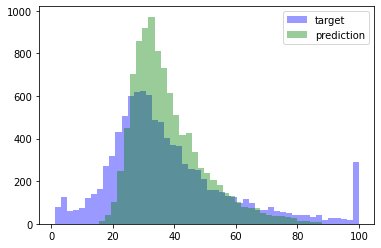

In [21]:
plt.hist(oof_df['Pawpularity'].values, alpha = 0.4, color = 'b', label = 'target', bins = 50)
pred_bins = int((np.max(oof_df['pred'].values) - np.min(oof_df['pred'].values)) //2)
plt.hist(oof_df['pred'].values, alpha = 0.4, color = 'g', label = 'prediction', bins = pred_bins)
plt.legend()
plt.show()

### with TTA

In [22]:
# with TTA
for i in range(Config.n_fold):
    rmse_oof(oof_tta_df, i)
rmse_oof(oof_tta_df)
oof_tta_df.to_csv('oof_tta.csv', index=False)

fold 0: 17.737544237385713
fold 1: 17.831066130953207
fold 2: 17.629045238376573
fold 3: 17.633650741884423
fold 4: 17.15307516415288
overall: 17.59847092382805


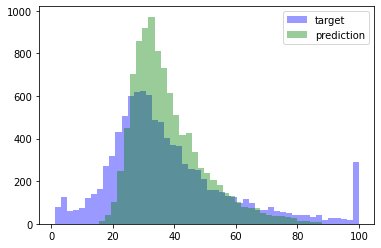

In [23]:
plt.hist(oof_tta_df['Pawpularity'].values, alpha = 0.4, color = 'b', label = 'target', bins = 50)
tta_pred_bins = int((np.max(oof_tta_df['pred'].values) - np.min(oof_tta_df['pred'].values)) //2)
plt.hist(oof_df['pred'].values, alpha = 0.4, color = 'g', label = 'prediction', bins = tta_pred_bins)
plt.legend()
plt.show()